In [122]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.fftpack import dctn, idctn
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2gray
%matplotlib inline

In [123]:
img = io.imread('starry_night.jpg')
img = img.astype('float32') / 255 # normalize
# reduce contrast to prevent clipping in frequency domain operation
REDUCE_RATIO = 0.95
REDUCE_OFFSET = (1 - REDUCE_RATIO) / 2
img = (img * REDUCE_RATIO) + REDUCE_OFFSET

In [54]:
import struct
encodeimg = 'small.jpg'
with open(encodeimg, 'rb') as f:
    content = f.read()
encodestring = content

Original Image Information
Max: 0.9749999642372131
Min: 0.02500000037252903
Type: float32
Shape: (950, 1199, 3)


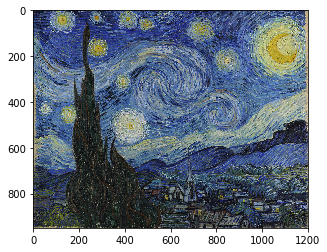

In [55]:
# original image information
print("Original Image Information")
print("Max: {}\nMin: {}".format(img.max(), img.min()))
print("Type: {}".format(img.dtype))
print("Shape: {}".format(img.shape))
plt.imshow(img)

DCT Image Information
Max: 466.95196533203125
Min: -71.90155792236328
Mean: 0.0004010933043900877
Type: float32
Shape: (950, 1199, 3)


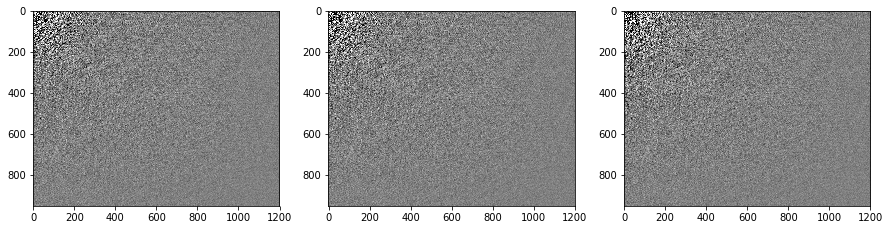

In [56]:
img_dct = dctn(img, axes=[0,1], norm='ortho')
print("DCT Image Information")
print("Max: {}\nMin: {}".format(img_dct.max(), img_dct.min()))
print("Mean: {}".format(img_dct.mean()))
print("Type: {}".format(img_dct.dtype))
print("Shape: {}".format(img_dct.shape))
# plot dct maps
NORM_BOUND = 0.5
img_dct_copy = img_dct.copy()

plt.figure(figsize=(15,4))
plt.subplot(131); plt.imshow(img_dct_copy[:,:,0], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(132); plt.imshow(img_dct_copy[:,:,1], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(133); plt.imshow(img_dct_copy[:,:,2], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')

In [102]:
MAX_FREQ = 0.8
MIN_FREQ = 0.5
SCALE    = 5e-4
THRESH   = 256*SCALE

def encode(imdct, msg):
    cnt = 0
    h, w, c = imdct.shape
    length = struct.pack('I', len(msg))
    msg = length + msg
    for i in range(int(MAX_FREQ*h), int(MIN_FREQ*h), -1):
        for j in range(int(MAX_FREQ*w), int(MIN_FREQ*w), -1):
            for k in range(c):
                if cnt >= len(msg):
                    return
                if abs(imdct[i,j,k]) < THRESH:
                    imdct[i,j,k] = np.sign(imdct[i,j,k])*msg[cnt]*SCALE
                    cnt += 1

In [116]:
def decode(imdct):
    msg = b''
    h, w, c = imdct.shape
    length = 1e30
    cnt = 0
    for i in range(int(MAX_FREQ*h), int(MIN_FREQ*h), -1):
        for j in range(int(MAX_FREQ*w), int(MIN_FREQ*w), -1):
            for k in range(c):
                if len(msg) == length:
                    return msg
                if abs(imdct[i,j,k]) < THRESH:
                    msg += struct.pack('B', int(np.round(abs(imdct[i,j,k])/SCALE)))
                if len(msg) == 4 and length == 1e30:
                    length = struct.unpack('I', msg)[0]
                    msg = b''

In [117]:
# encoder / decoder unit test
#message = 'z'*4000 + 'A'*10000 + '`'*8000
message = encodestring
img_dct = dctn(img, axes=[0,1], norm='ortho')
encode(img_dct, message)
decode_msg = decode(img_dct)
assert decode_msg == message, 'Encode / Decode Failure\nDecoded: {}'.format(decode_msg)

Encoded DCT Image Information
Max: 466.95196533203125
Min: -71.90155792236328
Mean: 0.0003975912695750594
Type: float32
Shape: (950, 1199, 3)


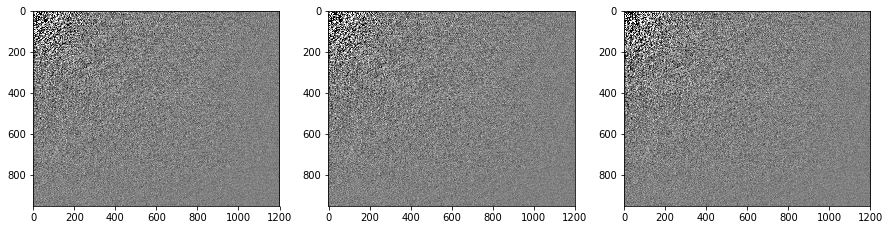

In [118]:
print("Encoded DCT Image Information")
print("Max: {}\nMin: {}".format(img_dct.max(), img_dct.min()))
print("Mean: {}".format(img_dct.mean()))
print("Type: {}".format(img_dct.dtype))
print("Shape: {}".format(img_dct.shape))
# plot dct maps
NORM_BOUND = 0.5
img_dct_copy = img_dct.copy()

plt.figure(figsize=(15,4))
plt.subplot(131); plt.imshow(img_dct_copy[:,:,0], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(132); plt.imshow(img_dct_copy[:,:,1], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')
plt.subplot(133); plt.imshow(img_dct_copy[:,:,2], vmin=-NORM_BOUND, vmax=NORM_BOUND, cmap='gray')

Recovered Image Information
Max: 0.9907560348510742
Min: 0.005413271486759186
Type: float32
Shape: (950, 1199, 3)


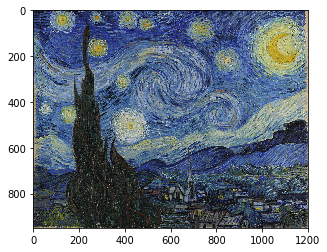

In [119]:
img_recov = idctn(img_dct, axes=[0,1], norm='ortho')
print("Recovered Image Information")
print("Max: {}\nMin: {}".format(img_recov.max(), img_recov.min()))
print("Type: {}".format(img_recov.dtype))
print("Shape: {}".format(img_recov.shape))
plt.imshow(img_recov)

In [120]:
# quantization test
QUANT_SCALE = 65535.
img_quantized = (img_recov * QUANT_SCALE).astype('uint16')
img_quant_dct = dctn(img_quantized/QUANT_SCALE, axes=[0,1], norm='ortho')
assert decode(img_quant_dct) == message, 'Reconstruct failed due to precision error'

In [124]:
# save image to disk
io.imsave('starry_encoded.tiff', img_quantized)

In [125]:
# recover from disk
img_read = io.imread('starry_encoded.tiff')
img_read_dct = dctn(img_read/QUANT_SCALE, axes=[0,1], norm='ortho')
decode(img_read_dct) == message

True

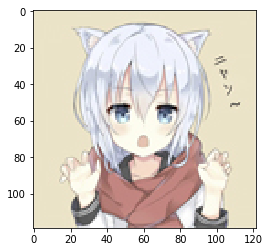

In [126]:
decodemsg = decode(img_read_dct)

from PIL import Image
import io

decodeimage = Image.open(io.BytesIO(decodemsg))
plt.imshow(decodeimage)

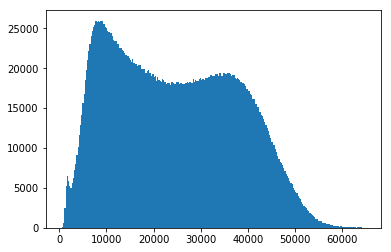

In [127]:
_ = plt.hist(img_read.flatten(), bins=256)

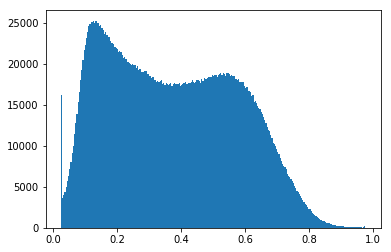

In [128]:
_ = plt.hist(img.flatten(), bins=256)